Attention based architectures work the best for this task. How do you classify Disposition vs NoDisposition?
Errors will propagate through the multiple classification tasks that are present.
- Bio-BERT for embeddings
- Attention layer
- Bi LSTM
- Since the training data is small, it makes sense to do cross-validation on the training data. How to select the number of folds?


Questions and comments
- Should all of the text be used as features or only a select few?
- Each record has multiple entity occurances that can correspond to an event. How to structure the training dataset in that case?
- How can you make the model focus on those entity occurances?
- 

Ideas
- Look for the nearest punctuation mark(period, Question mark, exclamation, on either sides of the medicine entity occurance and cut that off as a datapoint. In that way, we will have multiple sentences coming off per clinical record and they can be then fed to a language model to learn embeddings and then followed by a neural architecture. 
- Or let the model dynamically choose the context window for the entity. How is this possible? Attention?
- If the above is not the way, how are we supposed to feed annotated data to a model?



In [ ]:
# function ClickConnect(){
#     console.log("Clicked on connect button"); 
#     document.querySelector("Put ID here").click() // Change id here
# }
# setInterval(ClickConnect,60000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install wandb
!pip install trains

hyperparameter optimization

In [ ]:
# from trains.automation import UniformParameterRange, UniformIntegerParameterRange
# from trains.automation import HyperParameterOptimizer
# from trains.automation.optuna import OptimizerOptuna

In [ ]:
# from trains import Task
# task = Task.init(project_name='CMEDClassification', task_name='disposition')

In [ ]:
import glob,os,time,timeit,re
import pandas as pd
import numpy as np
import torch


address= "/content/drive/MyDrive/Dataset_pls/CMED21/data/"
train_textfile_list= sorted(glob.glob(address+'train/*.txt'))
train_annfile_list= sorted(glob.glob(address+'train/*.ann'))

print(str(train_textfile_list[0]),str(train_annfile_list[0]),sep='\n')

f = open(train_annfile_list[10], "r")
g = open(train_textfile_list[10], "r")
# print(f.read())
# print(g.read())


/content/drive/MyDrive/Dataset_pls/CMED21/data/train/100-01.txt
/content/drive/MyDrive/Dataset_pls/CMED21/data/train/100-01.ann


In [ ]:
len(train_textfile_list)
train_textfile_list[1]

'/content/drive/MyDrive/Dataset_pls/CMED21/data/train/100-02.txt'

In [ ]:
test_textfile_list= sorted(glob.glob(address+'test/*.txt'))
test_annfile_list= sorted(glob.glob(address+'test/*.ann'))

# print(str(test_textfile_list[0]),str(test_annfile_list[0]),sep='\n')

f = open(test_annfile_list[12], "r")
g = open(test_textfile_list[12], "r")
# print(f.read())
# print(g.read())
#collect all text files into a single list 
start = timeit.default_timer()
mr_train= []
mr_test = []

for file in train_textfile_list:
  g = open(file, "r")
  mr_train.append(g.read())

for file in test_textfile_list:
  g = open(file, "r")
  mr_test.append(g.read())


stop = timeit.default_timer()

print("train ={}, test={}".format(len(mr_train), len(mr_test)))
print('Time: ', stop - start) 
mr_train[1]

train =400, test=100
Time:  141.4041662789998


"\n\n\nRecord date: 2108-03-14\n\n                     CAMPBELL EMERGENCY DEPT VISIT\n\n \n\nVALDEZ,HARLAN,JR.   845-41-54-4                VISIT DATE: 03/14/08\n\nThe patient was seen and examined in the emergency department.  The \n\npatient was seen by the Emergency Medicine resident.  I have \n\ndiscussed the management with the resident.  I have also seen the \n\npatient primarily and reviewed the medical record.  This is a brief \n\naddendum to the medical record.\n\nHISTORY OF PRESENTING COMPLAINT:  Briefly, this is a 45-year-old \n\nmale who complains of several days of nausea, vomiting, and left \n\nlower quadrant discomfort.  He also describes intermittent chest \n\npain, which he has had for a number of months without significant \n\nchange.  He was sent in from his primary care doctor today with \n\nthis pain and was also noted to have some EKG changes.  The patient \n\nhas no chest pain at the time of evaluation in the emergency \n\ndepartment and no shortness of breath.\n

We assume that there is a system that has already identified the location of the medication in the EMR like in the training annotation files.

In [ ]:
#storing data
class mention:
  def __init__(self,term_id,event_id,startchar,endchar,medication,disposition,action,temporality,certainty,actor,negation):
    self.term_id = term_id
    self.event_id = event_id
    self.startchar= startchar
    self.endchar= endchar
    self.medication = medication
    self.disposition = disposition
    self.action= action
    self.temporality= temporality
    self.certainty= certainty
    self.actor= actor
    self.negation= negation
  def print_record(self):
    # print("printing record")
    print(self.term_id,
    self.event_id,
    self.startchar,
    self.endchar,
    self.medication,
    self.disposition,
    self.action,
    self.temporality,
    self.certainty,
    self.actor,
    self.negation)

In [ ]:
#parse annotation file
def parse_ann(annfile):
  mention_list=[]
  # print(annfile)
  f= open(annfile,'r')
  temp= f.read()
  # print(f.read())
  x=temp.splitlines()
  # print(len(x))
  # print(x)
  t_list=[]
  a_list=[]
  e_dict= dict()
  t_dict= dict()

  for y in x:
    if y[0] =='E':
      zx= re.split('[\t:]',y.rstrip())
      # print(zx)
      m= mention(zx[2],zx[0],'100','100','none',zx[1],'none','none','none','none','none')
      mention_list.append(m)
      e_dict[str(zx[0])] = zx[2]

    if y[0] == 'T':
      z= re.split('[\t]',y)
      # print(z)
      split= re.split('[ ]',z[1])
      for u in split:
        if ';' not in u:
          z.insert(1,u)
      z.pop(4)
      
      # print(z)
      t_list.append(z)
      # t_dict[re.sub('T','E',z[0])]=z
      t_dict[z[0]]=z

      
    if y[0] == 'A':
      zz= re.split('[ \t]',y)
      # print(zz)
      a_list.append(zz)
 

  for t in t_list:
    for m in mention_list:
      # print(m.term_id, t[0])
      if (m.term_id == t[0]):
        # print("assigning")
        # print(t)
        
        m.startchar = t[2]
        m.endchar = t[1]
        m.disposition = t[3]
        m.medication = t[4]
  
  for a in a_list:
    # print(a)
    for m in mention_list:
      if a[2]== m.event_id:
        if a[1] == 'Action':
          m.action= a[3]
        elif a[1] == 'Temporality':
          m.temporality= a[3]
        elif a[1] == 'Certainity': 
          m.certainty= a[3] 
        elif a[1] == 'Actor':
          m.actor= a[3]
        elif a[1] == 'Negation':
          m.negation= a[1]

  return mention_list

In [ ]:
# parsing annotation file
i=0
text_repeats = []
text_label=[]
ann_list=[]
full_df= pd.DataFrame()
all_medication_mention_list =[]

# ann_dict = parse_ann(train_annfile_list[1])
for annfile in train_annfile_list:
    temp_medmention= parse_ann(annfile)
    all_medication_mention_list+= temp_medmention
    
    df=pd.DataFrame([o.__dict__ for o in temp_medmention])
    text_repeats.append(len(temp_medmention))
    df['docno']= list(np.repeat(i,df.shape[0]))
    df['file_location'] = [train_textfile_list[i] for j in range(df.shape[0])]
    full_df= pd.concat([full_df,df]).reset_index(drop=True)
    
    txt=mr_train[i]
    # text_label.extend([txt,ann])
    i+=1
    
# text_label[1]
# ann_list[10]
# full_df
# full_df.to_csv("/content/drive/MyDrive/Dataset_pls/CMED21/train_set.csv")
print(len(text_repeats))
print(full_df.shape)
print(len(all_medication_mention_list))
print(full_df.shape)
print(full_df.head(2))

400
(7230, 13)
7230
(7230, 13)
  term_id event_id  ... docno                                      file_location
0      T1       E1  ...   0.0  /content/drive/MyDrive/Dataset_pls/CMED21/data...
1      T2       E2  ...   0.0  /content/drive/MyDrive/Dataset_pls/CMED21/data...

[2 rows x 13 columns]


In [ ]:
print(full_df.shape)
print(full_df.columns)
j=0
text_col=[]
for text in mr_train:
  for r in range(text_repeats[j]):
    text_col.append(text)

  j+=1
print(len(text_col))
full_df['text']= text_col
print(full_df.head(5))
full_df.to_csv("/content/drive/MyDrive/Dataset_pls/CMED21/train_set.csv")

(7230, 13)
Index(['term_id', 'event_id', 'startchar', 'endchar', 'medication',
       'disposition', 'action', 'temporality', 'certainty', 'actor',
       'negation', 'docno', 'file_location'],
      dtype='object')
7230
  term_id  ...                                               text
0      T1  ...  \n\n\nRecord date: 2106-02-12\n\nCampbell Orth...
1      T2  ...  \n\n\nRecord date: 2106-02-12\n\nCampbell Orth...
2      T3  ...  \n\n\nRecord date: 2106-02-12\n\nCampbell Orth...
3      T4  ...  \n\n\nRecord date: 2106-02-12\n\nCampbell Orth...
4      T3  ...  \n\n\nRecord date: 2109-09-14\n\n \nSeptember ...

[5 rows x 14 columns]


Preprocessing Text

In [ ]:
mr_train[16]

"\n\n\nRecord date: 2100-04-27\n\n \n\nHAWTHORNE STATE HOSPITAL\n\nREDDING, LOUISIANA\n\n\n\nGI CONSULT NOTE\n\n4/28/2100\n\n\n\nPatient name: Oreilly, Gabrielle\n\nMRN: 9868572\n\nConsult Attending: Matthew Vieira\n\n\n\nReason for consult: BRBPR, some black stool\n\n\n\nHPI: The patient is a 76 year old female on chronic aspirin therapy, with distant history of PUD admit with three days of BRBPR.  Passed moderate volume of BRB into bowl, with some loose black stool at the bottom.  No tarry stool, mostly red.  Started to take peptobismol and from then on passed mostly red blood with some dark stool.  Two episodes each day since then.  Felt lightheaded the first day, none since.  Overall, feels weak, but not ill.  No abdominal pain or even significant cramping.  No epigastric discomfort.  No nausea, vomiting, fevers, chills.  No unusual ingestions or sick contacts.  Currently feels well, hungry.\n\n\n\nTakes aspirin daily, baby.  In past occasionally took NSAIDs for leg pain, none rece

In [ ]:
# extract only the n characters on the either side of the medication occurance
spans= []
starts= list(full_df['startchar'])
ends= list(full_df['endchar'])
# print(starts)
context_window_chars = 200

for i in range(len(starts)):
  txt= full_df.iloc[i]['text']
  if int(starts[i]) <200:
    start= 0
  else:
    start = int(starts[i]) - context_window_chars
  # print(i)
  if int(ends[i]) == len(txt):
    end= len(txt)
  else:  
    end= int(ends[i]) + context_window_chars
  
  #preprocessing text
  txt= txt.strip()
  txt = txt.replace('\n',' ')

  #extracting span
  x= txt[start:end]
  spans.append(x) 

# print(i)
print(len(spans))
full_df['spans']= spans

7230


In [ ]:
print(full_df['spans'][1],'\n', full_df['medication'][1])

ring, and he is using a cane.  He is here for routine follow-up.  Past medical history is notable for no ankle injuries previously.  He has a history of diabetes and sleep apnea.  He takes Prozac, Cardizem, Glucophage and Amaryl.  He is also followed by Dr. Harold Nutter for an arrhythmia.  He does not smoke.  He drinks minimally.  He is a set designer at Columbia Pictures.   On examination today he has s 
 Cardizem


In [ ]:
full_df.to_csv("/content/drive/MyDrive/Dataset_pls/CMED21/data/data_with_spans.csv")

Sentence based extraction

In [ ]:
import nltk
nltk.download('punkt')
j=16
sentences = nltk.sent_tokenize(full_df['text'][j])
disposition_indices= []
for i in range(full_df.shape[0]):
  if full_df['disposition'][i] =="Disposition" :
    disposition_indices.append(i)
print(disposition_indices)
print(full_df['medication'][j],full_df['disposition'][j],full_df['startchar'][j],full_df['endchar'][j],full_df['docno'][j],full_df['file_location'][j])

# sentences
sum=0
mr_train[2][9664:9666]
lengths = [len(x) for x in sentences]
for i,x in enumerate(lengths):
  sum= sum+x+1
  if sum>9664:
    print(i)
    break
# sentences
mr_train[2]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[12, 16, 22, 23, 25, 50, 51, 52, 53, 54, 55, 56, 63, 71, 77, 78, 104, 105, 107, 108, 109, 117, 118, 119, 121, 126, 127, 128, 130, 136, 146, 176, 177, 179, 180, 183, 200, 201, 202, 203, 204, 205, 206, 207, 260, 261, 287, 302, 314, 316, 332, 333, 370, 371, 372, 373, 374, 375, 377, 378, 381, 382, 383, 385, 395, 397, 406, 407, 408, 411, 416, 419, 421, 443, 454, 455, 456, 463, 464, 467, 468, 470, 471, 472, 474, 475, 477, 478, 495, 502, 505, 517, 518, 519, 522, 538, 539, 541, 557, 560, 562, 564, 565, 568, 569, 573, 583, 594, 595, 596, 597, 598, 599, 603, 604, 622, 623, 625, 626, 628, 694, 706, 707, 708, 709, 710, 717, 718, 719, 720, 730, 731, 732, 733, 734, 735, 736, 737, 741, 742, 743, 744, 748, 749, 750, 751, 752, 753, 754, 755, 757, 758, 759, 773, 796, 797, 814, 815, 830, 831, 832, 833, 834, 835, 874, 878, 879, 880, 900, 902, 913, 916, 926, 939, 940, 943, 948, 960, 961, 989, 990, 995,

'\n\n\nRecord date: 2109-09-14\n\n \nSeptember 14, 2109 \n \nVicente Blair, M.D.  \nInternal Medical \nDoctors Hospital North \nOmak, Georgia 72196 \n \nRE: VALDEZ, Harlan \nDHN#: 7672624 \nDATE OF BIRTH: 11/09/2062 \nCURRENT CLINIC VISIT DATE: 09/14/2109 \n \nDear Vicente, \n \nThank you in advance for allowing me to share in the medical care of Mr. Harlan B. Valdez, a 46-year-old male patient with prior polysomnographic evidence of sleep disordered breathing, as well as a history of difficulty in sleep, reinitiation and maintenance and increased early morning awakenings, as well as mixed systemic medical conditions.  \n \nHISTORY OF PRESENT ILLNESS: As you already know, Mr. Valdez who demonstrates a history of difficulties of sleep reinitiation and maintenance, as well as increased early morning awakenings, has noted an exacerbation of these sleep difficulties, occurring in temporal association with his loss of his wife from pancreatic cancer last year. He is now placed in the unfort

In [ ]:
print(sentences[i])
mr_train[2][9650:9675]

If he proves poorly responsive to trial of BIPAP therapy however, I might consider supplemental O2 therapy at night and, with this in mind a follow up sleep study should have associated end-tidal CO2 monitoring as well.


' supplemental O2 therapy '

In [ ]:
type(list(full_df['spans']))

list

Text Preprocessing
- Remove all white spaces
- Tokenize with Clinical BERT
- Embeddings with Clinical BERT


In [ ]:
# Clinical BERT
%%capture
!pip install git+https://github.com/huggingface/transformers
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")


In [ ]:
# Text preprocessing
input = tokenizer(list(full_df['spans']),return_tensors="pt",padding=True)
#output= clinical_bert_model(**input)
input[1]

Encoding(num_tokens=219, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
full_df['tokenizedtext'] = list(input['input_ids'].numpy())
print(full_df['tokenizedtext'][1])
len(full_df['tokenizedtext'][1])

[  101  3170   117  1105  1119  1110  1606   170 14671   119  1119  1110
  1303  1111  9285  2812   118  1146   119  1763  2657  1607  1110  3385
  1111  1185 10845  5917  2331   119  1119  1144   170  1607  1104 17972
  1105  2946   170  1643 25362   119  1119  2274  5250 25616   117  3621
  3708  1306   117   176  7535  2528 20695  2176  1105  1821  3113  1233
   119  1119  1110  1145  1723  1118   173  1197   119  5871 13166  1181
 22664  2083  1111  1126   170 11096  7889  1582  8191   119  1119  1674
  1136  5427   119  1119  8898 10298  1193   119  1119  1110   170  1383
  5592  1120  1884  7776 10242  5324   119  1113  8179  2052  1119  1144
   188   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

219

Creating date-wise folders for storing experimental outputs

In [ ]:
from datetime import date
from datetime import datetime
import os

today = str(date.today())
folder_address = "/content/drive/MyDrive/Dataset_pls/CMED21/output/"
# dd/mm/YY H:M:S

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y-%H-%M-%S")
print("date and time =", dt_string)	

try:
  os.mkdir(folder_address+dt_string)
  print("folder created")
except OSError as e:
  print("file exists")

output_path = folder_address+dt_string+"/"
output_path

date and time = 23-03-2021-16-54-27
folder created


'/content/drive/MyDrive/Dataset_pls/CMED21/output/23-03-2021-16-54-27/'

In [ ]:
folder_address+dt_string

'/content/drive/MyDrive/Dataset_pls/CMED21/output/23-03-2021-16-54-27'

In [ ]:
full_df.head(5)
print(full_df.shape)
only_disp_fulldf= full_df.loc[full_df['disposition'] == 'Disposition']
only_disp_fulldf.head(5)
only_disp_fulldf.shape

print(only_disp_fulldf['action'].value_counts())
print("---------------------------------")
print(only_disp_fulldf['temporality'].value_counts())
print("---------------------------------")
print(only_disp_fulldf['certainty'].value_counts())
print("--------------------------------")
print(only_disp_fulldf['actor'].value_counts())
print("---------------------------------")

full_df.to_csv(output_path+"traindata.csv")

(7230, 16)
Start          568
Stop           341
UniqueDose     285
Increase       129
Decrease        54
Unknown         35
OtherChange      1
Name: action, dtype: int64
---------------------------------
Past       745
Present    494
Future     145
Unknown     29
Name: temporality, dtype: int64
---------------------------------
Certain         1177
Hypothetical     134
Conditional      100
Unknown            2
Name: certainty, dtype: int64
--------------------------------
Physician    1278
Patient       107
Unknown        28
Name: actor, dtype: int64
---------------------------------


Data exploration

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


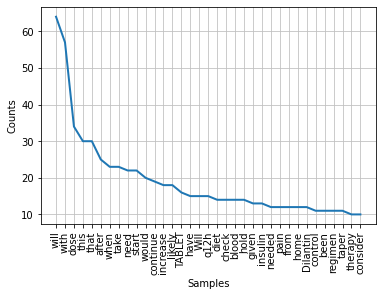

In [ ]:
import nltk
nltk.download('punkt')

from nltk import ngrams, FreqDist
spans= list(only_disp_fulldf.loc[only_disp_fulldf['certainty']== 'Conditional']['spans'])

xx= ' '.join(spans)
words = nltk.word_tokenize(xx)
all_counts = FreqDist(words)

filter_words = dict([(m, n) for m, n in all_counts.items() if len(m) > 3])

# for key in sorted(filter_words):
#   print("%s: %s" % (key, filter_words[key]))

data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(35, cumulative=False)


In [ ]:
x= full_df.dropna(subset=['spans'])
x.shape
print(full_df.loc[748,'file_location'])
print(full_df.file_location.loc[[6858]])

/content/drive/MyDrive/Dataset_pls/CMED21/data/train/131-02.txt
6858    /content/drive/MyDrive/Dataset_pls/CMED21/data...
Name: file_location, dtype: object


Remove Unknown and OtherChange records (<40) during cross validation

In [ ]:
input[2]
y= full_df['disposition']
len(y)
y.value_counts()

NoDisposition    5260
Disposition      1413
Undetermined      557
Name: disposition, dtype: int64

Bi-directional LSTM classifier class
```
- batch_size : Fixed Size of the batch 5
- output_size : 3 (Disposition vs No Disposition vs unknown)
- hidden_size : 256 
- vocab_size : Size of the vocabulary from train data
- embedding_length : length of Embeddding dimension from Bio-BERT
- word_embeddings : Bio-BERT
- bidirectional : Flag that indicates if the model should be bidirectional or not

```

In [ ]:
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self,bert,hidden_dim,output_dim,n_layers,bidirectional,dropout):
        super().__init__()
        print("================================================================") 
        self.bert = bert
        self.hidden_size = hidden_dim * 2 if bidirectional else hidden_dim
        self.bidirectional = bidirectional
        self.n_layers = n_layers
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, num_layers = n_layers, bidirectional=bidirectional)
        # self.rnn = nn.GRU(embedding_dim,hidden_dim,num_layers = n_layers,bidirectional = bidirectional,batch_first = True,
        #                   dropout = 0 if n_layers < 2 else dropout)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(self.hidden_size, 256)
        self.fc2 = nn.Linear(256, output_dim)
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(dropout)

    
    def init_hidden(self, biflag, batch_size):
        return(Variable(torch.zeros(biflag, batch_size, self.hidden_size)).to(device),
                        Variable(torch.zeros(biflag, batch_size, self.hidden_size)).to(device))
       
    def forward(self, text, batch_size):
        with torch.no_grad():
            embedded = self.bert(text)[0] #calling bio-bert 
        embedded = embedded.permute(1, 0, 2)      # change order of    
        if(self.bidirectional == True):
            self.hidden = self.init_hidden(2 * self.n_layers, batch_size)
        else:
            self.hidden = self.init_hidden(1 * self.n_layers, batch_size)       

        output, (final_hidden_state, final_cell_state) = self.lstm(embedded, self.hidden)
        #hidden = [n layers * n directions, batch size, emb dim]

        relu = self.relu(final_hidden_state[-1])      
        dense1 = self.fc1(relu)
        drop = self.dropout(dense1)       
        final_output = self.softmax(self.fc2(drop))
        
        return final_output

Hyperparameters for LSTM class

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
hyperparameters = [HIDDEN_DIM,OUTPUT_DIM ,N_LAYERS,BIDIRECTIONAL,DROPOUT]
print(hyperparameters)
model = BiLSTM(clinical_bert_model,HIDDEN_DIM,OUTPUT_DIM,N_LAYERS,BIDIRECTIONAL,DROPOUT)

[256, 3, 2, True, 0.25]


In [ ]:
# model

In [ ]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f'The model has {count_parameters(model):,} trainable parameters')

Training function

Hyperparameter optimization fn

In [ ]:
hyp_optimizer = HyperParameterOptimizer(
    base_task_id=TEMPLATE_TASK_ID,  
    # setting the hyper-parameters to optimize
    hyper_parameters=[
        UniformIntegerParameterRange('number_of_epochs', min_value=2, max_value=12, step_size=2),
        UniformIntegerParameterRange('batch_size', min_value=2, max_value=16, step_size=2),
        UniformParameterRange('dropout', min_value=0, max_value=0.5, step_size=0.05),
        UniformParameterRange('base_lr', min_value=0.00025, max_value=0.01, step_size=0.00025),
    ],
    # setting the objective metric we want to maximize/minimize
    objective_metric_title='accuracy',
    objective_metric_series='total',
    objective_metric_sign='max',  

    # setting optimizer 
    optimizer_class=OptimizerOptuna,
    
    # Configuring optimization parameters
    execution_queue='dan_queue',  
    max_number_of_concurrent_tasks=2,  
    optimization_time_limit=60., 
    compute_time_limit=120, 
    total_max_jobs=20,  
    min_iteration_per_job=15000,  
    max_iteration_per_job=150000,  
)

NameError: ignored

In [ ]:
from torch.nn import functional as F
criterion = F.cross_entropy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#criterion = criterion.to(device)

In [ ]:
def fileexists(filename):
  if os.path.exists(filename):
    return 'a' # append if already exists
  else:
    return 'w' # make a new file if not

In [ ]:
   """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

def multi_accuracy(preds, y, filename = "", save = False):
    p = preds.argmax(dim=1).cpu().numpy() #Predictions               
    r = y.float()[:, 0].data.cpu().numpy() #Truth

    if save == True:
      pfilename = str(output_path)+str(filename)+"_p.txt"
      # print(pfilename)
      predictionfile = open(pfilename, fileexists(pfilename))
      np.savetxt(predictionfile, p, fmt='%5d', delimiter=',')
      predictionfile.close()

      afilename = str(output_path)+str(filename)+"_a.txt"
      # print(afilename)
      actualfile = open(afilename, fileexists(afilename))
      
      np.savetxt(actualfile, r, fmt='%5d', delimiter=',')
      actualfile.close()

    return np.sum(p == r)    
    

In [ ]:
from torch.autograd import Variable
def train(model, train_tsdata, optimizer, criterion, batch_size):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    train_loader = torch.utils.data.DataLoader(train_tsdata, batch_size=batch_size, shuffle=True)
    for x_batch, y_batch in train_loader:
      
      X = Variable(torch.LongTensor(x_batch)).to(device)
      y = Variable(torch.LongTensor(y_batch.long())).to(device)
      
      optimizer.zero_grad()
      predictions = model(X, X.shape[0])
      
      if X.shape[0] == 1:
        loss = criterion(predictions.view(-1), y.view(-1))
      else:
        loss = criterion(predictions.squeeze(), y.squeeze())
      
      acc = multi_accuracy(predictions.squeeze(), y, "",batch_size)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
      loss.backward()        
      optimizer.step()
        
    return epoch_loss / len(train_loader), epoch_acc / len(train_tsdata)

In [ ]:
def evaluate(model, valid_tsdata, criterion, batch_size, filename, save):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    valid_loader = torch.utils.data.DataLoader(valid_tsdata, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for x_batch, y_batch in valid_loader:
          X_val = Variable(torch.LongTensor(x_batch)).to(device)
          y_val = Variable(torch.LongTensor(y_batch.long())).to(device)
          predictions_val = model(X_val, X_val.shape[0])

          loss = criterion(predictions_val.squeeze(), y_val.squeeze())
 
          acc = multi_accuracy(predictions_val.squeeze(), y_val, filename,save)
          epoch_loss += loss.item()
          epoch_acc += acc.item()
        
    return epoch_loss / len(valid_loader), epoch_acc / len(valid_tsdata)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Train Evaluate method

In [ ]:
def train_evaluate(model,train_tsdata, val_tsdata,optimizer, criterion, batchsize,learningrate,filename, n_epochs=5):
  N_EPOCHS = n_epochs
  tloss = []
  vloss = []
  tacc = []
  vacc = []
  savepredictions = False
  best_valid_loss = float('inf')

  for epoch in range(N_EPOCHS):
      
      start_time = time.time()
      
      if epoch == N_EPOCHS-1:
        savepredictions = True
      
      train_loss, train_acc = train(model, train_tsdata, optimizer, criterion, batchsize)
      valid_loss, valid_acc = evaluate(model, val_tsdata, criterion, batchsize,filename,savepredictions)

      tloss.append(train_loss)
      vloss.append(valid_loss)
      tacc.append(train_acc)
      vacc.append(valid_acc)
          
      end_time = time.time()
          
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
          
      # if valid_loss < best_valid_loss:
      #     best_valid_loss = valid_loss
      #     torch.save(model.state_dict(), output_path+filename+"-model.pt")
      
      epoch_file_name= output_path+"epoch_details.txt"
      epoch_file = open(epoch_file_name,fileexists(epoch_file_name))
      print("Task,Epoch,Batchsize,learningrate,Train_Loss,Train Acc,ValLoss,ValAcc",file=epoch_file)
      if epoch <= (N_EPOCHS -1):

        print("Batch size:{} Task: {}".format(batchsize,filename))
        print(f'Epoch: {epoch+1:02} Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} Val. Acc: {valid_acc*100:.2f}%')

        
        print("{},{},{},{},{},{},{},{}".format(filename,epoch+1,batchsize,learningrate,train_loss,train_acc,valid_loss,valid_acc),file=epoch_file)
        # print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s',file=epoch_file)
        # print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',file=epoch_file)
        # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%',file=epoch_file)
        

  return best_valid_loss,tloss,vloss,tacc,vacc

In [ ]:
device

device(type='cuda')

 Disposition TASK- Stratified K fold Cross Validation- 3 folds

- Set Batch Size
- Set n_epochs

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import torch.optim as optim
import random

import matplotlib.pyplot as plt
label= ['disposition','action','certainty','temporality','actor']
skf = StratifiedKFold(n_splits=3)
le = preprocessing.LabelEncoder()

X= full_df[['tokenizedtext']]
y= full_df[[label[0]]]
skf.get_n_splits(X,y)

#============================
# batchsize= [32,64,128,256]
# lr= [0.01,0.001,0.0001,0.00001]
# n_epochs = [100,200,500]
batchsize = 100
n_epochs = 100
learning_rate = 0.01
filename = label[0]
#=============================

fold = 0
random.seed(10)
# for b in batchsize:
#   for l in lr:
#     for epochs in n_epochs:
for train_index, val_index in skf.split(X,y):
        fold += 1
        optimizer = optim.Adam(model.parameters(),lr= learning_rate)
        optimizer2 = optim.ASGD(model.parameters())

        print("TRAIN:", train_index, "Valid:", val_index)
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # print(X_train)
        yt = le.fit_transform(y_train.values)
        yv = le.transform(y_val.values)
        
        X_train.reset_index(drop= True, inplace = True)
        y_train.reset_index(drop= True, inplace = True)
        X_val.reset_index(drop= True, inplace = True)
        y_val.reset_index(drop= True, inplace = True)

        yt = torch.from_numpy(yt.reshape((y_train.shape[0],-1))).float()
        xt = torch.tensor(X_train['tokenizedtext'])
        train_tsdata = torch.utils.data.TensorDataset(xt, yt)

        yv = torch.from_numpy(yv.reshape((y_val.shape[0],-1))).float()
        xv = torch.tensor(X_val['tokenizedtext'])
        val_tsdata = torch.utils.data.TensorDataset(xv, yv)
        
        filename = filename + "fold" + str(fold)
        best_valid_loss,tloss,vloss,tacc,vacc = train_evaluate(model,train_tsdata, val_tsdata,optimizer, criterion, batchsize,learning_rate,filename,n_epochs)
        
        plt.title("Train and Validation Loss")
        plt.plot(tloss,label='train loss')
        plt.plot(vloss,label='validation loss')
        plt.legend()
        plt.savefig(output_path+"loss_plot.png")
        plt.show()
        print(best_valid_loss,vacc)



Get the class level accuracy

In [ ]:
import numpy as np
import pandas as pd

def read_predictions(output_path, taskname):
  try:
    preds = np.loadtxt(output_path + taskname +"_p.txt").astype(int).tolist()
    truth = np.loadtxt(output_path + taskname +"_a.txt").astype(int).tolist()
    analysisdf = pd.DataFrame(list(zip(truth, preds)), columns = ['truth', 'predictions'])
    print(analysisdf.shape)
    print("truth \n", analysisdf['truth'].value_counts())
    print("predictions \n",analysisdf['predictions'].value_counts())
    # print(analysisdf.head(5))
  except:
    print("prediction files not found")
    analysisdf= pd.DataFrame(data=None)
  return analysisdf

In [ ]:
output_path

'/content/drive/MyDrive/Dataset_pls/CMED21/output/23-03-2021-16-54-27/'

'NoDisposition': 0, 'Disposition': 1, 'Undetermined': 2

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import metrics, preprocessing
import os

numfolds = 3
n = 0
if output_path == "":
  output_path = "/content/drive/My Drive/Dataset_pls/CMED21/output/22-03-2021-22-40-11/"

while n < numfolds:
  n += 1
  taskname = "dispositionfold" + str(n)

  analysisdf = read_predictions(output_path, taskname)

  y_true= analysisdf['truth']
  y_pred= analysisdf['predictions']


  f1_disp_micro= f1_score(y_true, y_pred, average='micro')
  f1_disp_macro= f1_score(y_true, y_pred, average='macro')

  p_disp_micro= precision_score(y_true, y_pred, average='micro')
  p_disp_macro= precision_score(y_true, y_pred, average='macro')

  r_disp_micro= recall_score(y_true, y_pred, average='micro')
  r_disp_macro= recall_score(y_true, y_pred, average='macro')

  target_names = list(le.classes_)
  
  result_report = open(output_path+"classification_report_disp.txt", fileexists(output_path+"classification_report_disp.txt"))
  print(datetime, file = result_report)
  print(metrics.classification_report(y_true, y_pred, target_names=target_names),file=result_report)


  print("f-1 score micro is:{} \n f-1 score macro is:{}".format(f1_disp_micro,f1_disp_macro))
  print("f-1 score micro is", f1_disp_micro, "\n f-1 score macro is: ",f1_disp_macro, file=result_report)
  print("precision micro is", p_disp_micro, "\n precision macro is: ",p_disp_macro, file=result_report)
  print("recall micro is", r_disp_micro, "\n recall macro is: ",r_disp_macro, file=result_report)
  result_report.close()
  # disp = analysisdf[analysisdf['truth'] == 0]
  # print(disp.shape)
  # print("accuracy of disposition {}". format(len(nodisp[nodisp['predictions'] == 0])/len(nodisp)))
  # nodisp = analysisdf[analysisdf['truth'] == 1]
  # print(nodisp.shape)
  # print("accuracy of disposition {}". format(len(disp[disp['predictions'] == 1])/len(disp)))
  # undet = analysisdf[analysisdf['truth'] == 2]
  # print(undet.shape)
  # print("accuracy of undetermined {}". format(len(undet[undet['predictions'] == 2])/len(undet)))

(2410, 2)
truth 
 1    1754
0     471
2     185
Name: truth, dtype: int64
predictions 
 1    2410
Name: predictions, dtype: int64
f-1 score micro is:0.7278008298755186 
 f-1 score macro is:0.2808197246237592
(2410, 2)
truth 
 1    1753
0     471
2     186
Name: truth, dtype: int64
predictions 
 1    2410
Name: predictions, dtype: int64
f-1 score micro is:0.7273858921161825 
 f-1 score macro is:0.2807270397950196
(2410, 2)
truth 
 1    1753
0     471
2     186
Name: truth, dtype: int64
predictions 
 1    2410
Name: predictions, dtype: int64
f-1 score micro is:0.7273858921161825 
 f-1 score macro is:0.2807270397950196


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We will first create a working architecture that will perform all the classification tasks. In our case, we will use the BiLSTM for all the tasks. The embeddings are shared across tasks using Bio-BERT. Once we have separate trained models for each of the tasks, then it is time to explore ways for these individual models to 'talk' to each other. 
- https://ruder.io/multi-task/ has a brief overview of methods in multi-task learning

Now, the nature of the classification tasks are not significantly different from each other. Each task picks on a part of the text from the sentence that conveys the meaning.
While we have an array of methods that deal with multi-task learning problems, not all of them apply here.

Questions-
- Can we share some parameters for learning among the tasks?
- Eavesdropping
- Soft Parameter sharing

Questions about Deep Learning experimentation
- Should we add more layers?
- Should we test for more iterations?
- What other architectures should we experiment with?

Other 4 tasks

In [ ]:
HIDDEN_DIM = 256
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

In [ ]:
print("{} \n Shape of only disp {}".format(only_disp_fulldf['certainty'].value_counts(),only_disp_fulldf.shape))
only_disp_fulldf.columns

Certain         1177
Hypothetical     134
Conditional      100
Unknown            2
Name: certainty, dtype: int64 
 Shape of only disp (1413, 16)


Index(['term_id', 'event_id', 'startchar', 'endchar', 'medication',
       'disposition', 'action', 'temporality', 'certainty', 'actor',
       'negation', 'docno', 'file_location', 'text', 'spans', 'tokenizedtext'],
      dtype='object')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import matplotlib.pyplot as plt


label= ['certainty','temporality','action','actor']
# label= ['certainty']

for l in label:
  #Filter out records for which the class count is less than < 40
  sub_only_disp_df = only_disp_fulldf.copy()
  sub_only_disp_df = sub_only_disp_df[sub_only_disp_df.groupby(l)[l].transform('count')>40]
  sub_only_disp_df.reset_index(drop= True, inplace = True)
  print(sub_only_disp_df[l].value_counts())
  
  #k fold cross validation(k=3)
  n_splits=5
  skf = StratifiedKFold(n_splits)
  le = preprocessing.LabelEncoder()

  X= sub_only_disp_df[['tokenizedtext']]
  y= sub_only_disp_df[[l]]
  skf.get_n_splits(X,y)
  
  #=====================================
  # SET BATCHSIZE AND N_EPOCHS
  batchsize=15
  n_epochs_new = 200
  learning_rate = 0.001
  #=============================================

  i = 0
  countr = 0
  for train_index, val_index in skf.split(X,y):
    countr+=1
    optimizer = optim.Adam(model.parameters(),lr= learning_rate)
    # optimizer2 = optim.ASGD(model.parameters())

    print("-----------------------------------", l ,"-----------------------------------")
    i+=1
    print("cross validation {} of {}".format(i,n_splits))
    output_dim = y[l].nunique()
    #print("output dimension ", output_dim)
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train.reset_index(drop= True, inplace = True)
    y_train.reset_index(drop= True, inplace = True)
    X_val.reset_index(drop= True, inplace = True)
    y_val.reset_index(drop= True, inplace = True)

    print("xtrain =", X_train.shape, " XVal =", X_val.shape, " y_train= ", y_train.shape, " y_val=",y_val.shape)
    le = preprocessing.LabelEncoder()
    yt = le.fit_transform(y_train[l].values)
    yv = le.transform(y_val[l].values)
    # xt = torch.from_numpy(traindata['tokenizedtext'].values).float()
    yt = torch.from_numpy(yt.reshape((y_train[l].shape[0],-1))).float()
    xt = torch.tensor(X_train['tokenizedtext'])
    train_tsdata = torch.utils.data.TensorDataset(xt, yt)
    # valid_tsdata = torch.utils.data.TensorDataset(valdata)
    #print(np.unique(yv))
    yv = torch.from_numpy(yv.reshape((y_val[l].shape[0],-1))).float()
    xv = torch.tensor(X_val['tokenizedtext'])
    val_tsdata = torch.utils.data.TensorDataset(xv, yv)

    other_model = BiLSTM(clinical_bert_model,HIDDEN_DIM,output_dim,N_LAYERS,BIDIRECTIONAL,DROPOUT)
    other_model = other_model.to(device)
    
    best_valid_loss,tloss,vloss,tacc,vacc =  train_evaluate(other_model,train_tsdata, val_tsdata,optimizer, criterion, batchsize,learning_rate,l + "folds" + str(countr),n_epochs_new)
                                              
    plt.title("Train and Validation Loss")
    plt.plot(tloss,label='train loss')
    plt.plot(vloss,label='validation loss')
    plt.legend()

    plt.show()
    print("best validation loss is ", best_valid_loss)

Certain         1177
Hypothetical     134
Conditional      100
Name: certainty, dtype: int64
----------------------------------- certainty -----------------------------------
cross validation 1 of 5
xtrain = (1128, 1)  XVal = (283, 1)  y_train=  (1128, 1)  y_val= (283, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Batch size:15 Task: certaintyfolds1
Epoch: 01 Epoch Time: 0m 17s
	Train Loss: 1.105 Train Acc: 7.80%
	 Val. Loss: 1.104 Val. Acc: 7.07%
Batch size:15 Task: certaintyfolds1
Epoch: 02 Epoch Time: 0m 17s
	Train Loss: 1.105 Train Acc: 7.27%
	 Val. Loss: 1.104 Val. Acc: 7.07%
Batch size:15 Task: certaintyfolds1
Epoch: 03 Epoch Time: 0m 17s
	Train Loss: 1.105 Train Acc: 7.54%
	 Val. Loss: 1.104 Val. Acc: 7.07%
Batch size:15 Task: certaintyfolds1
Epoch: 04 Epoch Time: 0m 17s
	Train Loss: 1.105 Train Acc: 7.18%
	 Val. Loss: 1.104 Val. Acc: 7.07%
Batch size:15 Task: certaintyfolds1
Epoch: 05 Epoch Time: 0m 17s
	Train Loss: 1.105 Train Acc: 7.27%
	 Val. Loss: 1.104 Val. Acc: 7.07%
Batch size:15 Task: certaintyfolds1
Epoch: 06 Epoch Time: 0m 17s
	Train Loss: 1.105 Train Acc: 7.36%
	 Val. Loss: 1.104 Val. Acc: 7.07%
Batch size:15 Task: certaintyfolds1
Epoch: 07 Epoch Time: 0m 17s
	Train Loss: 1.105 Train Acc: 8.78%
	 Val. Loss: 1.104 Val. Acc: 7.07%
Batch size:15 Task: certaintyfolds1
Epoch: 08 Ep

In [ ]:
le.classes_

array(['Certain', 'Conditional', 'Hypothetical'], dtype=object)

Error Analysis

In [ ]:
def read_predictions(taskname):
  try:
    preds = np.loadtxt("/content/drive/My Drive/Dataset_pls/CMED21/output/"+ taskname +"_p.txt").astype(int).tolist()
    truth = np.loadtxt("/content/drive/My Drive/Dataset_pls/CMED21/output/"+ taskname +"_a.txt").astype(int).tolist()
    analysisdf = pd.DataFrame(list(zip(truth, preds)), columns = ['truth', 'predictions'])
    print(analysisdf.shape)
    # print(analysisdf.head(5))
  except:
    print("no files exist.")
    analysisdf= pd.DataFrame(data=None)
  return analysisdf

In [ ]:
output_path
output_path = "/content/drive/My Drive/Dataset_pls/CMED21/output/23-03-2021-05-10-59/"

In [ ]:
from sklearn.metrics import accuracy_score

label= ['certainty','temporality','action','actor']
for l in label:
  numfolds = 5
  n = 0
  while n < numfolds:
    n += 1
    print("-----------"+ l +"---------------")
    taskname = l+"folds"+ str(n)
    output_df = read_predictions(output_path, taskname)
    y_true= output_df['truth']
    y_pred= output_df['predictions']

    sub_only_disp_df = only_disp_fulldf.copy()
    sub_only_disp_df = sub_only_disp_df[sub_only_disp_df.groupby(l)[l].transform('count')>40]
    sub_only_disp_df.reset_index(drop= True, inplace = True)
    
    print(sub_only_disp_df.shape)
    print(sub_only_disp_df[l].value_counts())
    
    sub_only_disp_df['pred']= y_pred
    sub_only_disp_df['truth'] = y_true
    print("Truth distribution:{}".format(sub_only_disp_df['truth'].value_counts()))
    print("-----------------------")
    print("Prediction distribution:{}".format(sub_only_disp_df['pred'].value_counts()))
    print("-----------------------")
    
    #create csv file
    sub_only_disp_df.to_csv("/content/drive/My Drive/Dataset_pls/CMED21/output/"+l+"_errors.csv")
    
    #overall Accuracy score
    print(accuracy_score(y_true, y_pred,normalize=True, sample_weight=None))
    # computing class level accuracies
    analysisdf = sub_only_disp_df.copy()
    sub_labels= list(sub_only_disp_df[l].unique())
    print(sub_labels)

    for i,s in enumerate(sub_labels):
      sub_class = analysisdf[analysisdf['truth'] == i]
      # print(sub_class.shape)
      print(" {} Predicted correctly:{} out of {}".format(s,len(sub_class[sub_class['pred'] == i]),len(sub_class)))
      print("accuracy of {} {}". format(s,len(sub_class[sub_class['pred'] == i])/len(sub_class)))
      i+=1
    
    f1_disp_micro= f1_score(y_true, y_pred, average='micro')
    f1_disp_macro= f1_score(y_true, y_pred, average='macro')

    p_disp_micro= precision_score(y_true, y_pred, average='micro')
    p_disp_macro= precision_score(y_true, y_pred, average='macro')

    r_disp_micro= recall_score(y_true, y_pred, average='micro')
    r_disp_macro= recall_score(y_true, y_pred, average='macro')

    target_names = list(sub_labels)
    
    result_report = open(output_path+"classification_report_disp.txt", fileexists(output_path+"classification_report_disp.txt"))
    print("========================== " + taskname + " ==========================", file = result_report)
    print(metrics.classification_report(y_true, y_pred, target_names=target_names),file=result_report)


    print("f-1 score micro is:{} \n f-1 score macro is:{}".format(f1_disp_micro,f1_disp_macro))
    print("f-1 score micro is", f1_disp_micro, "\n f-1 score macro is: ",f1_disp_macro, file=result_report)
    print("precision micro is", p_disp_micro, "\n precision macro is: ",p_disp_macro, file=result_report)
    print("recall micro is", r_disp_micro, "\n recall macro is: ",r_disp_macro, file=result_report)
    result_report.close()
print("-----------------------")

  

-----------certainty---------------
(283, 2)
truth 
 0    236
2     27
1     20
Name: truth, dtype: int64
predictions 
 1    250
0     33
Name: predictions, dtype: int64
(1411, 16)
Certain         1177
Hypothetical     134
Conditional      100
Name: certainty, dtype: int64
Truth distribution:0.0    236
2.0     27
1.0     20
Name: truth, dtype: int64
-----------------------
Prediction distribution:1.0    250
0.0     33
Name: pred, dtype: int64
-----------------------
0.1625441696113074
['Certain', 'Conditional', 'Hypothetical']
 Certain Predicted correctly:27 out of 236
accuracy of Certain 0.11440677966101695
 Conditional Predicted correctly:19 out of 20
accuracy of Conditional 0.95
 Hypothetical Predicted correctly:0 out of 27
accuracy of Hypothetical 0.0
f-1 score micro is:0.1625441696113074 
 f-1 score macro is:0.11382807838817753
-----------certainty---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(282, 2)
truth 
 0    236
2     26
1     20
Name: truth, dtype: int64
predictions 
 1    282
Name: predictions, dtype: int64
(1411, 16)
Certain         1177
Hypothetical     134
Conditional      100
Name: certainty, dtype: int64
Truth distribution:0.0    236
2.0     26
1.0     20
Name: truth, dtype: int64
-----------------------
Prediction distribution:1.0    282
Name: pred, dtype: int64
-----------------------
0.07092198581560284
['Certain', 'Conditional', 'Hypothetical']
 Certain Predicted correctly:0 out of 236
accuracy of Certain 0.0
 Conditional Predicted correctly:20 out of 20
accuracy of Conditional 1.0
 Hypothetical Predicted correctly:0 out of 26
accuracy of Hypothetical 0.0
f-1 score micro is:0.07092198581560284 
 f-1 score macro is:0.04415011037527594
-----------certainty---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(282, 2)
truth 
 0    235
2     27
1     20
Name: truth, dtype: int64
predictions 
 1    247
2     35
Name: predictions, dtype: int64
(1411, 16)
Certain         1177
Hypothetical     134
Conditional      100
Name: certainty, dtype: int64
Truth distribution:0.0    235
2.0     27
1.0     20
Name: truth, dtype: int64
-----------------------
Prediction distribution:1.0    247
2.0     35
Name: pred, dtype: int64
-----------------------
0.08156028368794327
['Certain', 'Conditional', 'Hypothetical']
 Certain Predicted correctly:0 out of 235
accuracy of Certain 0.0
 Conditional Predicted correctly:20 out of 20
accuracy of Conditional 1.0
 Hypothetical Predicted correctly:3 out of 27
accuracy of Hypothetical 0.1111111111111111
f-1 score micro is:0.08156028368794327 
 f-1 score macro is:0.0821956425435947
-----------certainty---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(282, 2)
truth 
 0    235
2     27
1     20
Name: truth, dtype: int64
predictions 
 1    282
Name: predictions, dtype: int64
(1411, 16)
Certain         1177
Hypothetical     134
Conditional      100
Name: certainty, dtype: int64
Truth distribution:0.0    235
2.0     27
1.0     20
Name: truth, dtype: int64
-----------------------
Prediction distribution:1.0    282
Name: pred, dtype: int64
-----------------------
0.07092198581560284
['Certain', 'Conditional', 'Hypothetical']
 Certain Predicted correctly:0 out of 235
accuracy of Certain 0.0
 Conditional Predicted correctly:20 out of 20
accuracy of Conditional 1.0
 Hypothetical Predicted correctly:0 out of 27
accuracy of Hypothetical 0.0
f-1 score micro is:0.07092198581560284 
 f-1 score macro is:0.04415011037527594
-----------certainty---------------
(282, 2)
truth 
 0    235
2     27
1     20
Name: truth, dtype: int64
predictions 
 1    279
2      3
Name: predictions, dtype: int64
(1411, 16)
Certain         1177
Hypothetical     134
Cond

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.06382978723404255
['Certain', 'Conditional', 'Hypothetical']
 Certain Predicted correctly:0 out of 235
accuracy of Certain 0.0
 Conditional Predicted correctly:18 out of 20
accuracy of Conditional 0.9
 Hypothetical Predicted correctly:0 out of 27
accuracy of Hypothetical 0.0
f-1 score micro is:0.06382978723404255 
 f-1 score macro is:0.04013377926421404
-----------temporality---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(277, 2)
truth 
 1    149
2     99
0     29
Name: truth, dtype: int64
predictions 
 0    277
Name: predictions, dtype: int64
(1384, 16)
Past       745
Present    494
Future     145
Name: temporality, dtype: int64
Truth distribution:1.0    149
2.0     99
0.0     29
Name: truth, dtype: int64
-----------------------
Prediction distribution:0.0    277
Name: pred, dtype: int64
-----------------------
0.10469314079422383
['Present', 'Future', 'Past']
 Present Predicted correctly:29 out of 29
accuracy of Present 1.0
 Future Predicted correctly:0 out of 149
accuracy of Future 0.0
 Past Predicted correctly:0 out of 99
accuracy of Past 0.0
f-1 score micro is:0.10469314079422383 
 f-1 score macro is:0.06318082788671024
-----------temporality---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(277, 2)
truth 
 1    149
2     99
0     29
Name: truth, dtype: int64
predictions 
 2    277
Name: predictions, dtype: int64
(1384, 16)
Past       745
Present    494
Future     145
Name: temporality, dtype: int64
Truth distribution:1.0    149
2.0     99
0.0     29
Name: truth, dtype: int64
-----------------------
Prediction distribution:2.0    277
Name: pred, dtype: int64
-----------------------
0.3574007220216607
['Present', 'Future', 'Past']
 Present Predicted correctly:0 out of 29
accuracy of Present 0.0
 Future Predicted correctly:0 out of 149
accuracy of Future 0.0
 Past Predicted correctly:99 out of 99
accuracy of Past 1.0
f-1 score micro is:0.3574007220216607 
 f-1 score macro is:0.17553191489361705
-----------temporality---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(277, 2)
truth 
 1    149
2     99
0     29
Name: truth, dtype: int64
predictions 
 0    259
2     18
Name: predictions, dtype: int64
(1384, 16)
Past       745
Present    494
Future     145
Name: temporality, dtype: int64
Truth distribution:1.0    149
2.0     99
0.0     29
Name: truth, dtype: int64
-----------------------
Prediction distribution:0.0    259
2.0     18
Name: pred, dtype: int64
-----------------------
0.10830324909747292
['Present', 'Future', 'Past']
 Present Predicted correctly:25 out of 29
accuracy of Present 0.8620689655172413
 Future Predicted correctly:0 out of 149
accuracy of Future 0.0
 Past Predicted correctly:5 out of 99
accuracy of Past 0.050505050505050504
f-1 score micro is:0.10830324909747292 
 f-1 score macro is:0.08636039886039885
-----------temporality---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(277, 2)
truth 
 1    149
2     99
0     29
Name: truth, dtype: int64
predictions 
 0    277
Name: predictions, dtype: int64
(1384, 16)
Past       745
Present    494
Future     145
Name: temporality, dtype: int64
Truth distribution:1.0    149
2.0     99
0.0     29
Name: truth, dtype: int64
-----------------------
Prediction distribution:0.0    277
Name: pred, dtype: int64
-----------------------
0.10469314079422383
['Present', 'Future', 'Past']
 Present Predicted correctly:29 out of 29
accuracy of Present 1.0
 Future Predicted correctly:0 out of 149
accuracy of Future 0.0
 Past Predicted correctly:0 out of 99
accuracy of Past 0.0
f-1 score micro is:0.10469314079422383 
 f-1 score macro is:0.06318082788671024
-----------temporality---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(276, 2)
truth 
 1    149
2     98
0     29
Name: truth, dtype: int64
predictions 
 2    216
1     60
Name: predictions, dtype: int64
(1384, 16)
Past       745
Present    494
Future     145
Name: temporality, dtype: int64
Truth distribution:1.0    149
2.0     98
0.0     29
Name: truth, dtype: int64
-----------------------
Prediction distribution:2.0    216
1.0     60
Name: pred, dtype: int64
-----------------------
0.37318840579710144
['Present', 'Future', 'Past']
 Present Predicted correctly:0 out of 29
accuracy of Present 0.0
 Future Predicted correctly:28 out of 149
accuracy of Future 0.18791946308724833
 Past Predicted correctly:75 out of 98
accuracy of Past 0.7653061224489796
f-1 score micro is:0.37318840579710144 
 f-1 score macro is:0.24854986336716137
-----------action---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(276, 2)
truth 
 2    114
3     68
4     57
1     26
0     11
Name: truth, dtype: int64
predictions 
 3    245
0     31
Name: predictions, dtype: int64
(1377, 16)
Start         568
Stop          341
UniqueDose    285
Increase      129
Decrease       54
Name: action, dtype: int64
Truth distribution:2.0    114
3.0     68
4.0     57
1.0     26
0.0     11
Name: truth, dtype: int64
-----------------------
Prediction distribution:3.0    245
0.0     31
Name: pred, dtype: int64
-----------------------
0.2210144927536232
['Start', 'Stop', 'Increase', 'UniqueDose', 'Decrease']
 Start Predicted correctly:2 out of 11
accuracy of Start 0.18181818181818182
 Stop Predicted correctly:0 out of 26
accuracy of Stop 0.0
 Increase Predicted correctly:0 out of 114
accuracy of Increase 0.0
 UniqueDose Predicted correctly:59 out of 68
accuracy of UniqueDose 0.8676470588235294
 Decrease Predicted correctly:0 out of 57
accuracy of Decrease 0.0
f-1 score micro is:0.2210144927536232 
 f-1 score macro is:0.0944469

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(276, 2)
truth 
 2    114
3     68
4     57
1     26
0     11
Name: truth, dtype: int64
predictions 
 0    127
3    114
4     29
1      6
Name: predictions, dtype: int64
(1377, 16)
Start         568
Stop          341
UniqueDose    285
Increase      129
Decrease       54
Name: action, dtype: int64
Truth distribution:2.0    114
3.0     68
4.0     57
1.0     26
0.0     11
Name: truth, dtype: int64
-----------------------
Prediction distribution:0.0    127
3.0    114
4.0     29
1.0      6
Name: pred, dtype: int64
-----------------------
0.10869565217391304
['Start', 'Stop', 'Increase', 'UniqueDose', 'Decrease']
 Start Predicted correctly:6 out of 11
accuracy of Start 0.5454545454545454
 Stop Predicted correctly:0 out of 26
accuracy of Stop 0.0
 Increase Predicted correctly:0 out of 114
accuracy of Increase 0.0
 UniqueDose Predicted correctly:20 out of 68
accuracy of UniqueDose 0.29411764705882354
 Decrease Predicted correctly:4 out of 57
accuracy of Decrease 0.07017543859649122
f-1 score m

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(275, 2)
truth 
 2    114
3     68
4     57
1     26
0     10
Name: truth, dtype: int64
predictions 
 3    275
Name: predictions, dtype: int64
(1377, 16)
Start         568
Stop          341
UniqueDose    285
Increase      129
Decrease       54
Name: action, dtype: int64
Truth distribution:2.0    114
3.0     68
4.0     57
1.0     26
0.0     10
Name: truth, dtype: int64
-----------------------
Prediction distribution:3.0    275
Name: pred, dtype: int64
-----------------------
0.24727272727272728
['Start', 'Stop', 'Increase', 'UniqueDose', 'Decrease']
 Start Predicted correctly:0 out of 10
accuracy of Start 0.0
 Stop Predicted correctly:0 out of 26
accuracy of Stop 0.0
 Increase Predicted correctly:0 out of 114
accuracy of Increase 0.0
 UniqueDose Predicted correctly:68 out of 68
accuracy of UniqueDose 1.0
 Decrease Predicted correctly:0 out of 57
accuracy of Decrease 0.0
f-1 score micro is:0.24727272727272728 
 f-1 score macro is:0.0793002915451895
-----------action---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(275, 2)
truth 
 2    113
3     69
4     57
1     25
0     11
Name: truth, dtype: int64
predictions 
 0    275
Name: predictions, dtype: int64
(1377, 16)
Start         568
Stop          341
UniqueDose    285
Increase      129
Decrease       54
Name: action, dtype: int64
Truth distribution:2.0    113
3.0     69
4.0     57
1.0     25
0.0     11
Name: truth, dtype: int64
-----------------------
Prediction distribution:0.0    275
Name: pred, dtype: int64
-----------------------
0.04
['Start', 'Stop', 'Increase', 'UniqueDose', 'Decrease']
 Start Predicted correctly:11 out of 11
accuracy of Start 1.0
 Stop Predicted correctly:0 out of 25
accuracy of Stop 0.0
 Increase Predicted correctly:0 out of 113
accuracy of Increase 0.0
 UniqueDose Predicted correctly:0 out of 69
accuracy of UniqueDose 0.0
 Decrease Predicted correctly:0 out of 57
accuracy of Decrease 0.0
f-1 score micro is:0.04 
 f-1 score macro is:0.015384615384615385
-----------action---------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(275, 2)
truth 
 2    113
3     68
4     57
1     26
0     11
Name: truth, dtype: int64
predictions 
 0    270
1      5
Name: predictions, dtype: int64
(1377, 16)
Start         568
Stop          341
UniqueDose    285
Increase      129
Decrease       54
Name: action, dtype: int64
Truth distribution:2.0    113
3.0     68
4.0     57
1.0     26
0.0     11
Name: truth, dtype: int64
-----------------------
Prediction distribution:0.0    270
1.0      5
Name: pred, dtype: int64
-----------------------
0.04363636363636364
['Start', 'Stop', 'Increase', 'UniqueDose', 'Decrease']
 Start Predicted correctly:11 out of 11
accuracy of Start 1.0
 Stop Predicted correctly:1 out of 26
accuracy of Stop 0.038461538461538464
 Increase Predicted correctly:0 out of 113
accuracy of Increase 0.0
 UniqueDose Predicted correctly:0 out of 68
accuracy of UniqueDose 0.0
 Decrease Predicted correctly:0 out of 57
accuracy of Decrease 0.0
f-1 score micro is:0.04363636363636364 
 f-1 score macro is:0.028561588795775462


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(277, 2)
truth 
 1    256
0     21
Name: truth, dtype: int64
predictions 
 1    256
0     21
Name: predictions, dtype: int64
(1385, 16)
Physician    1278
Patient       107
Name: actor, dtype: int64
Truth distribution:1.0    256
0.0     21
Name: truth, dtype: int64
-----------------------
Prediction distribution:1.0    256
0.0     21
Name: pred, dtype: int64
-----------------------
0.8483754512635379
['Physician', 'Patient']
 Physician Predicted correctly:0 out of 21
accuracy of Physician 0.0
 Patient Predicted correctly:235 out of 256
accuracy of Patient 0.91796875
f-1 score micro is:0.8483754512635379 
 f-1 score macro is:0.458984375
-----------actor---------------
(277, 2)
truth 
 1    256
0     21
Name: truth, dtype: int64
predictions 
 1    277
Name: predictions, dtype: int64
(1385, 16)
Physician    1278
Patient       107
Name: actor, dtype: int64
Truth distribution:1.0    256
0.0     21
Name: truth, dtype: int64
-----------------------
Prediction distribution:1.0    277
Name: pred

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(277, 2)
truth 
 1    256
0     21
Name: truth, dtype: int64
predictions 
 0    179
1     98
Name: predictions, dtype: int64
(1385, 16)
Physician    1278
Patient       107
Name: actor, dtype: int64
Truth distribution:1.0    256
0.0     21
Name: truth, dtype: int64
-----------------------
Prediction distribution:0.0    179
1.0     98
Name: pred, dtype: int64
-----------------------
0.37184115523465705
['Physician', 'Patient']
 Physician Predicted correctly:13 out of 21
accuracy of Physician 0.6190476190476191
 Patient Predicted correctly:90 out of 256
accuracy of Patient 0.3515625
f-1 score micro is:0.37184115523465705 
 f-1 score macro is:0.31923728813559327
-----------actor---------------
(277, 2)
truth 
 1    255
0     22
Name: truth, dtype: int64
predictions 
 1    277
Name: predictions, dtype: int64
(1385, 16)
Physician    1278
Patient       107
Name: actor, dtype: int64
Truth distribution:1.0    255
0.0     22
Name: truth, dtype: int64
-----------------------
Prediction distributi

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(277, 2)
truth 
 1    255
0     22
Name: truth, dtype: int64
predictions 
 0    277
Name: predictions, dtype: int64
(1385, 16)
Physician    1278
Patient       107
Name: actor, dtype: int64
Truth distribution:1.0    255
0.0     22
Name: truth, dtype: int64
-----------------------
Prediction distribution:0.0    277
Name: pred, dtype: int64
-----------------------
0.07942238267148015
['Physician', 'Patient']
 Physician Predicted correctly:22 out of 22
accuracy of Physician 1.0
 Patient Predicted correctly:0 out of 255
accuracy of Patient 0.0
f-1 score micro is:0.07942238267148015 
 f-1 score macro is:0.07357859531772576
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import metrics, preprocessing
import os

numfolds = 3
n = 0
if output_path == "":
  output_path = "/content/drive/My Drive/Dataset_pls/CMED21/output/22-03-2021-22-40-11/"

while n < numfolds:
  n += 1
  taskname = "dispositionfold" + str(n)

  analysisdf = read_predictions(output_path, taskname)

  y_true= analysisdf['truth']
  y_pred= analysisdf['predictions']


  f1_disp_micro= f1_score(y_true, y_pred, average='micro')
  f1_disp_macro= f1_score(y_true, y_pred, average='macro')

  p_disp_micro= precision_score(y_true, y_pred, average='micro')
  p_disp_macro= precision_score(y_true, y_pred, average='macro')

  r_disp_micro= recall_score(y_true, y_pred, average='micro')
  r_disp_macro= recall_score(y_true, y_pred, average='macro')

  # le = preprocessing.LabelEncoder()
  # le.fit_transform(y_true.values)

  target_names = list(le.classes_)
  
  result_report = open(output_path+"classification_report_disp.txt", fileexists(output_path+"classification_report_disp.txt"))
  print(datetime, file = result_report)
  print(metrics.classification_report(y_true, y_pred, target_names=target_names),file=result_report)


  print("f-1 score micro is:{} \n f-1 score macro is:{}".format(f1_disp_micro,f1_disp_macro))
  print("f-1 score micro is", f1_disp_micro, "\n f-1 score macro is: ",f1_disp_macro, file=result_report)
  print("precision micro is", p_disp_micro, "\n precision macro is: ",p_disp_macro, file=result_report)
  print("recall micro is", r_disp_micro, "\n recall macro is: ",r_disp_macro, file=result_report)
  result_report.close()
  # disp = analysisdf[analysisdf['truth'] == 0]
  # print(disp.shape)
  # print("accuracy of disposition {}". format(len(nodisp[nodisp['predictions'] == 0])/len(nodisp)))
  # nodisp = analysisdf[analysisdf['truth'] == 1]
  # print(nodisp.shape)
  # print("accuracy of disposition {}". format(len(disp[disp['predictions'] == 1])/len(disp)))
  # undet = analysisdf[analysisdf['truth'] == 2]
  # print(undet.shape)
  # print("accuracy of undetermined {}". format(len(undet[undet['predictions'] == 2])/len(undet)))

Validation with 80-20 train test split

In [ ]:
analysisdf[analysisdf['pred'] == 2].shape

(729, 17)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

label= ['action','certainty','temporality','actor']
for l in label:
  traindata, valdata = train_test_split(only_disp_fulldf[['tokenizedtext', l]], test_size=0.20, random_state=42)

  traindata.reset_index(drop= True, inplace = True)
  valdata.reset_index(drop= True, inplace = True)
  
  le = preprocessing.LabelEncoder()
  yt = le.fit_transform(traindata[l].values)
  yv = le.transform(valdata[l].values)
  # xt = torch.from_numpy(traindata['tokenizedtext'].values).float()
  yt = torch.from_numpy(yt.reshape((traindata[l].shape[0],-1))).float()
  xt = torch.tensor(traindata['tokenizedtext'])
  train_tsdata = torch.utils.data.TensorDataset(xt, yt)
  # valid_tsdata = torch.utils.data.TensorDataset(valdata)
  yv = torch.from_numpy(yv.reshape((valdata[l].shape[0],-1))).float()
  xv = torch.tensor(valdata['tokenizedtext'])
  val_tsdata = torch.utils.data.TensorDataset(xv, yv)


  other_model = BiLSTM(clinical_bert_model,HIDDEN_DIM,output_dim[l],N_LAYERS,BIDIRECTIONAL,DROPOUT)
  other_model = other_model.to(device)
  print(l)
  train_evaluate(other_model,train_tsdata, val_tsdata,optimizer, criterion, batchsize,l)